# 贪婪算法的不同和优化

## 现在将创建不同的 Agent 并统计平均值，后悔值，命中率

In [1]:
from typing import Callable, List, Tuple

from core import EpsilonDecreasingConfig, GreedyAgent, Rewards, \
    RLEnv
from train import train, AverageMetrics
from algorithms import greedy_average, epsilon_average, epsilon_decreasing_average
    
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import numpy as np

from pathlib import Path

In [2]:
SEED = 42
env = RLEnv(machine_count=100,seed=SEED)
COUNT = 50
STEPS = 10_000

In [3]:
def batch_train(
    count: int, 
    greedy_algorithm: Callable[..., int], 
    env: RLEnv, 
    epsilon_config: EpsilonDecreasingConfig, 
    steps: int,
    optimistic_init: bool,
    seed: int) -> Tuple[List[GreedyAgent], Rewards, AverageMetrics]:
    """批训练 Agent，传入数量，不同的算法，环境，步数和初始种子即可训练

    Args:
        count (int): 训练数量
        agent (GreedyAgent): 算法 类型
        env (RLEnv): 环境
        steps (int): 步数
        seed (int): 初始种子
        
    Returns:
        Tuple[List[GreedyAgent], Rewards]: 返回训练后的 agents 和平均后的奖励
    """
    _agents: List[GreedyAgent] = []
    
    if not callable(greedy_algorithm):
        raise ValueError("算法必须传入一个函数")
    
    for i in range(count):
        _agents.append(GreedyAgent(
            name=greedy_algorithm.__name__, # type: ignore # 在 callable 这里就已经验证了是一个函数，这里是为了避免 ty 工具误报
            env=env, 
            greedy_algorithm=greedy_algorithm,
            epsilon_config=epsilon_config,
            optimistic_init=optimistic_init,
            seed=seed + i
        ))
    
    agents, reward, metrics= train(_agents, steps)
  
    return agents, reward, metrics

def plot_metrics_history(agents: List[GreedyAgent], agent_name: str):
    """
    根据训练后的一组 agent 的 metrics_history 绘制指标变化图。

    Args:
        agents (List[GreedyAgent]): 经过训练的 agent 列表。
        agent_name (str): 这组 agent 的名称，用于图表标题。
    """
    
    if not agents:
        raise ValueError("Agents 列表为空，无法绘图")
    
    # 1. 设置字体
    font_path = Path.cwd() / "assets" / "微软雅黑.ttf"
    if font_path.exists():
        font_prop = FontProperties(fname=font_path, size=12)
        title_font_prop = FontProperties(fname=font_path, size=16)
        print("成功加载字体：", font_path)
    
    else:
        print(f"警告：找不到字体文件 {font_path}，将使用默认字体，中文可能显示为方框。")
        font_prop = FontProperties(size=12)
        title_font_prop = FontProperties(size=16)
        
    # 2. 准备数据
    num_steps: int = agents[0].steps
    
    avg_history = {
        "regret": np.zeros(num_steps),
        "regret_rate": np.zeros(num_steps),
        "total_reward": np.zeros(num_steps),
        "optimal_rate": np.zeros(num_steps)
    }
    
    # 遍历每个时间步
    for step_idx in range(num_steps):
        # 临时存储当前时间步所有 agent 的指标
        step_metrics = {
            "regret": [], "regret_rate": [], "total_reward": [], "optimal_rate": []
        }
        # 遍历每个 agent
        for agent in agents:
            # agent.metrics_history 的索引与 step_idx 一致
            if step_idx < len(agent.metrics_history):
                metrics_at_step = agent.metrics_history[step_idx][1] # (Rewards, Metrics, int) -> Metrics
                step_metrics["regret"].append(metrics_at_step.regret)
                step_metrics["regret_rate"].append(metrics_at_step.regret_rate)
                step_metrics["total_reward"].append(sum(metrics_at_step.rewards.values))
                step_metrics["optimal_rate"].append(metrics_at_step.optimal_rate)
        
        # 计算当前时间步的平均值并存入 avg_history
        for key in avg_history:
            if step_metrics[key]: # 确保列表不为空
                avg_history[key][step_idx] = np.mean(step_metrics[key])
                
    steps_axis = np.arange(1, num_steps + 1)
    
    # 3. 开始绘图
    fig, axes = plt.subplots(2, 2, figsize=(18, 12), dpi=100)
    fig.suptitle(f'"{agent_name}" 算法平均指标变化情况', fontproperties=title_font_prop)
    
    assert isinstance(axes, np.ndarray)
    axes = axes.flatten()
    
    plot_config = {
        "regret": "后悔值 (Regret)",
        "regret_rate": "后悔率 (Regret Rate)",
        "total_reward": "累积总奖励 (Total Reward)",
        "optimal_rate": "最优臂选择率 (Optimal Rate)",
    }
    
    for i, (metric_key, title) in enumerate(plot_config.items()):
        ax = axes[i]
        ax.plot(steps_axis, avg_history[metric_key], label=title)
        ax.set_title(title, fontproperties=font_prop)
        ax.set_xlabel("时间步 (Steps)", fontproperties=font_prop)
        ax.set_ylabel("平均值", fontproperties=font_prop)
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.legend(prop=font_prop)
        
    plt.tight_layout(rect=(0, 0, 1, 0.96))
    plt.show()

## 平均奖励

### 普通贪婪算法

成功加载字体： /home/Jese__Ki/Projects/learn/Python/rl_atomic/greedy/assets/微软雅黑.ttf


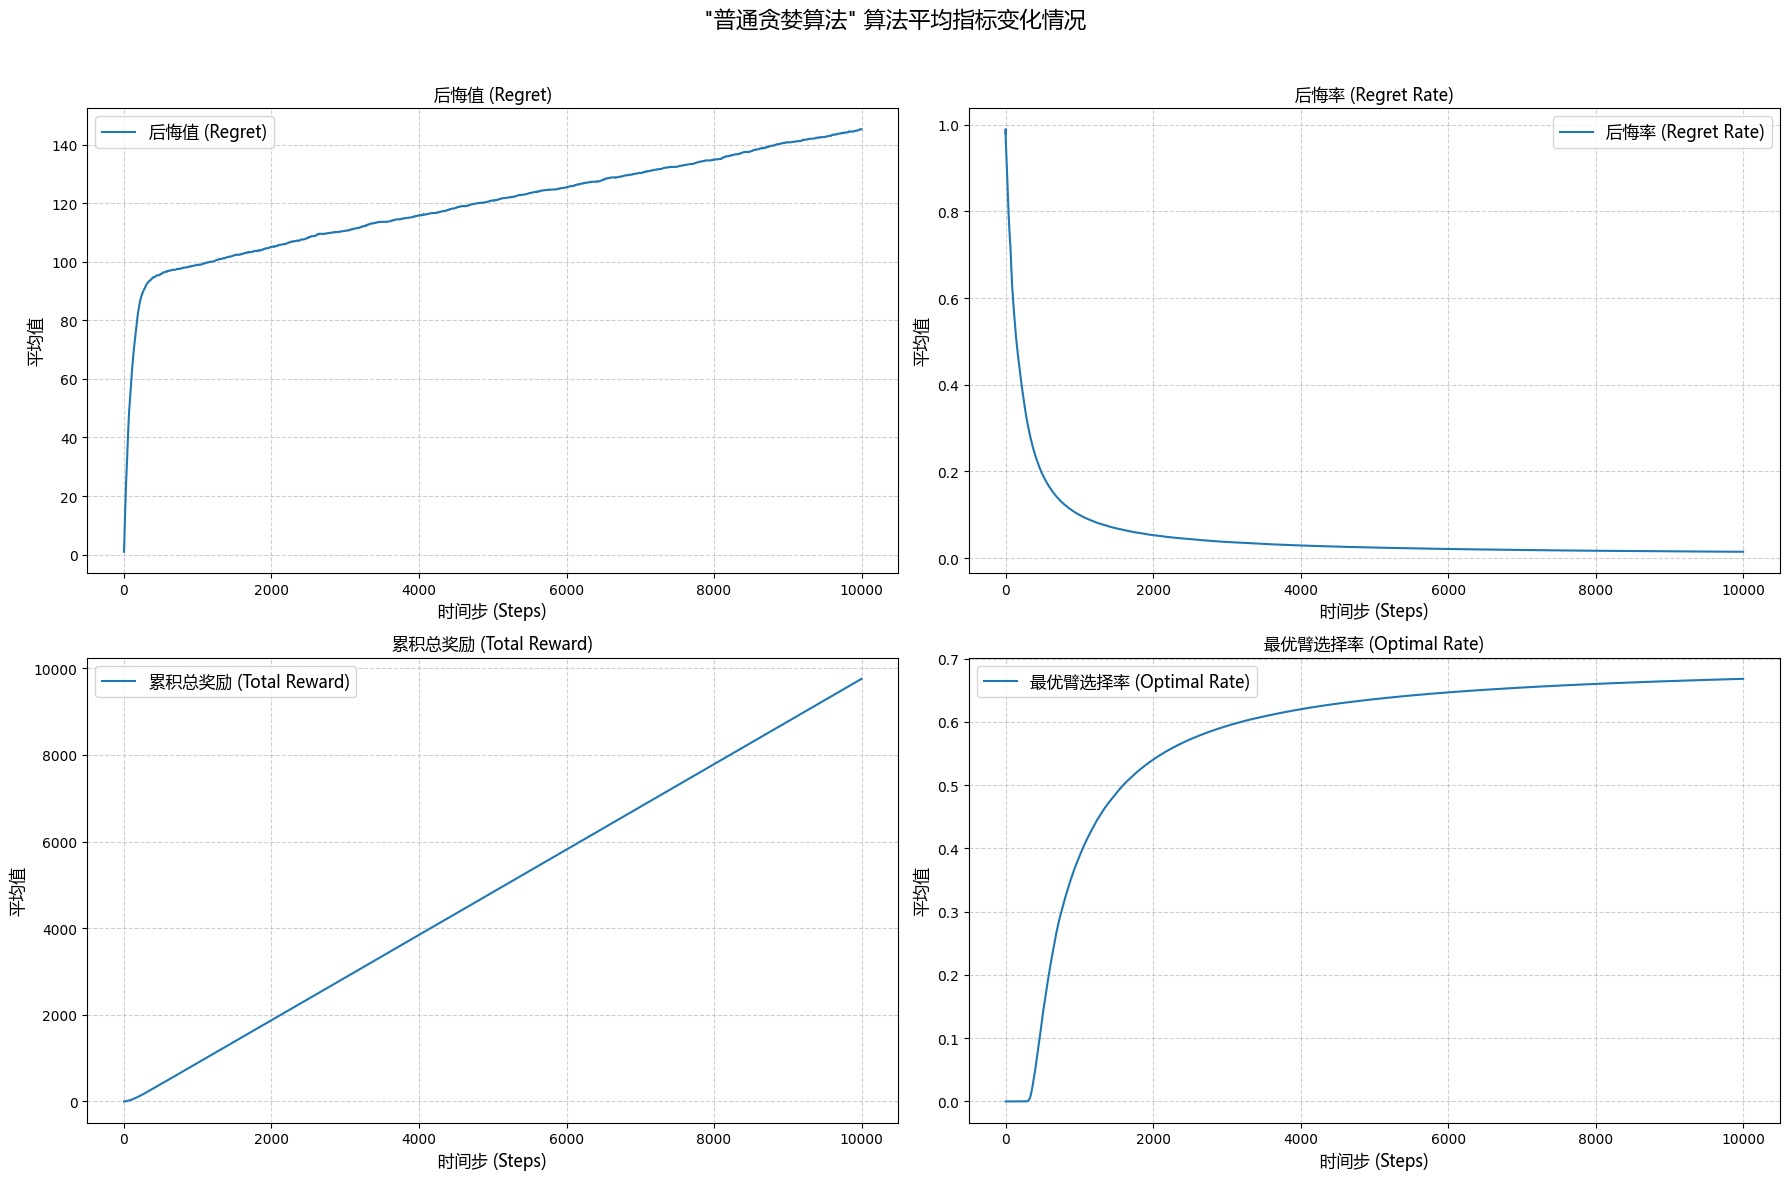

anget 名称: greedy_average
平均奖励：values=[0.02, 0.02, 0.06, 0.08, 0.1, 0.1, 0.1, 0.1, 0.14, 0.18, 0.2, 0.2, 0.2, 0.2, 0.2, 0.22, 0.24, 0.26, 0.26, 0.26, 0.28, 0.3, 0.38, 0.46, 0.46, 0.46, 0.48, 0.52, 0.54, 0.56, 0.56, 0.66, 0.66, 0.68, 0.7, 0.7, 0.74, 0.76, 0.86, 0.88, 0.94, 0.94, 0.98, 0.98, 0.98, 0.98, 1.0, 1.0, 1.0, 1.0, 1.0, 1.06, 1.06, 1.08, 1.2, 1.3, 1.36, 1.36, 1.38, 1.46, 1.56, 1.6, 1.66, 1.68, 2.02, 2.3, 2.36, 2.42, 2.5, 2.62, 2.66, 2.74, 2.88, 3.02, 3.04, 3.04, 3.06, 3.24, 3.32, 3.56, 3.6, 4.12, 4.12, 4.22, 4.24, 4.72, 5.22, 5.64, 6.76, 7.82, 8.52, 10.94, 11.98, 13.18, 14.66, 381.76, 32.96, 789.5, 1742.4, 6611.32] counts=[1.02, 1.02, 1.06, 1.08, 1.1, 1.1, 1.1, 1.1, 1.14, 1.18, 1.2, 1.2, 1.2, 1.2, 1.2, 1.22, 1.24, 1.26, 1.26, 1.26, 1.28, 1.3, 1.38, 1.46, 1.46, 1.46, 1.48, 1.52, 1.54, 1.56, 1.56, 1.66, 1.66, 1.68, 1.7, 1.7, 1.74, 1.76, 1.86, 1.88, 1.94, 1.94, 1.98, 1.98, 1.98, 1.98, 2.0, 2.0, 2.0, 2.0, 2.0, 2.06, 2.06, 2.08, 2.2, 2.3, 2.36, 2.36, 2.38, 2.46, 2.56, 2.6, 2.66, 2.68, 

In [4]:
# 普通贪婪算法的结果
agents, reward , metrics= batch_train(
    count=COUNT,
    greedy_algorithm=greedy_average,
    env=env, 
    epsilon_config=EpsilonDecreasingConfig(),
    steps=STEPS,
    optimistic_init=True,
    seed=SEED
)

plot_metrics_history(agents=agents, agent_name="普通贪婪算法")

print(
    f"anget 名称: {agents[0].name}"
    f"\n平均奖励：{reward}"
    f"\n指标：{metrics}"
)

### 随机探索贪婪算法

成功加载字体： /home/Jese__Ki/Projects/learn/Python/rl_atomic/greedy/assets/微软雅黑.ttf


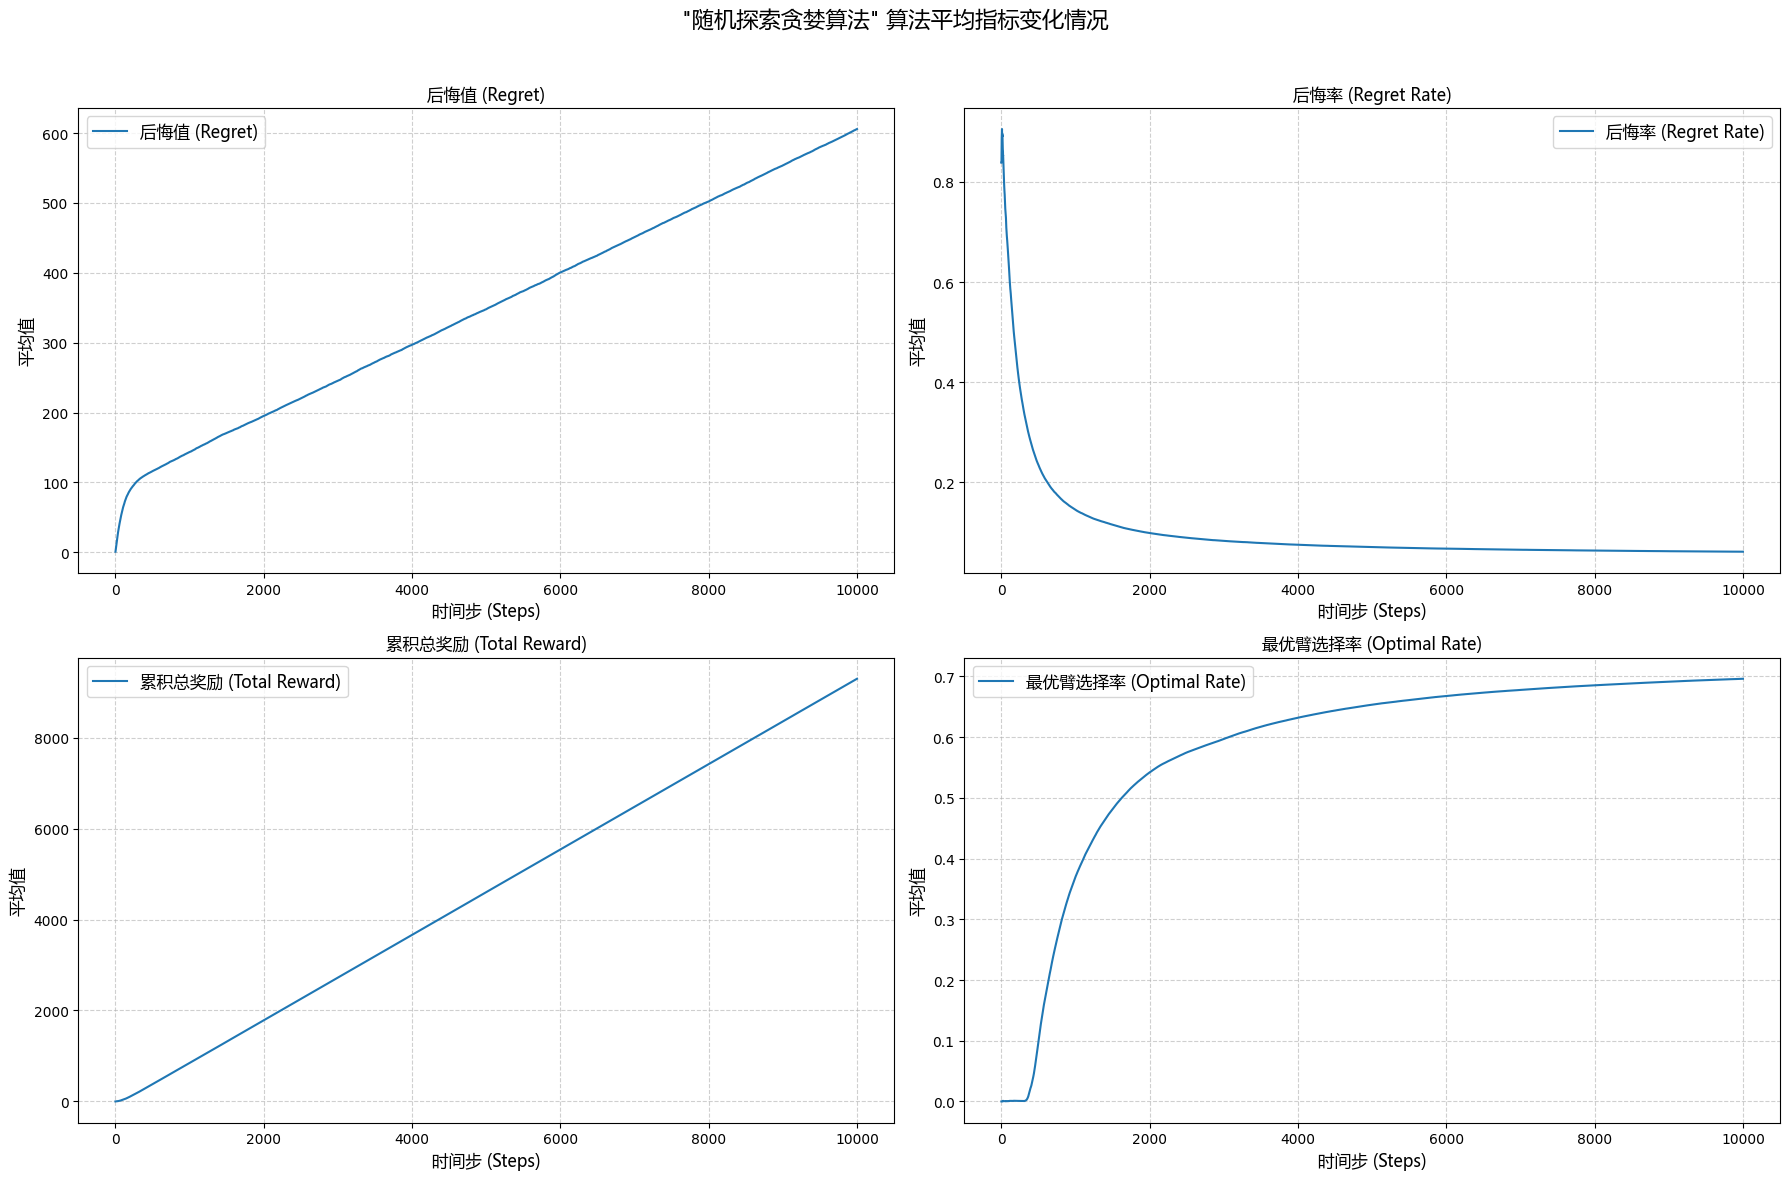

anget 名称: epsilon_average
平均奖励：values=[0.16, 0.24, 0.4, 0.44, 0.46, 0.54, 0.64, 0.78, 0.9, 1.04, 1.1, 1.3, 1.46, 1.72, 1.5, 1.72, 1.66, 1.84, 2.04, 1.94, 2.06, 2.24, 2.42, 2.74, 2.74, 3.0, 3.52, 3.54, 3.52, 3.46, 3.72, 3.74, 3.48, 4.28, 4.14, 3.98, 4.06, 4.26, 4.72, 4.72, 4.4, 4.86, 4.86, 5.2, 4.98, 5.3, 5.36, 5.48, 5.74, 5.86, 5.8, 6.0, 6.34, 6.2, 6.36, 6.68, 6.96, 6.24, 7.22, 7.6, 6.74, 7.9, 8.22, 8.1, 7.92, 8.26, 7.92, 8.2, 9.42, 8.64, 9.24, 9.96, 10.04, 9.9, 9.62, 10.24, 10.74, 11.36, 11.44, 11.4, 11.8, 13.28, 13.22, 13.5, 14.38, 13.94, 15.5, 14.06, 16.96, 18.52, 19.38, 21.88, 23.74, 24.16, 37.68, 32.34, 205.96, 380.58, 1116.04, 6893.42] counts=[10.54, 11.04, 10.86, 11.12, 11.08, 10.3, 11.02, 10.4, 10.82, 11.24, 10.3, 11.04, 11.06, 12.2, 10.76, 11.26, 10.46, 11.46, 11.78, 11.16, 11.08, 10.92, 10.96, 11.58, 11.16, 11.54, 12.42, 11.76, 11.34, 11.14, 11.46, 11.08, 10.5, 12.04, 11.48, 10.96, 11.0, 11.44, 12.48, 12.4, 11.16, 12.16, 11.46, 11.94, 11.06, 11.66, 11.48, 11.4, 11.74, 11.7, 1

In [5]:
# 随机探索贪婪算法的结果
agents, reward , metrics= batch_train(
    count=COUNT,
    greedy_algorithm=epsilon_average,
    env=env, 
    epsilon_config=EpsilonDecreasingConfig(),
    steps=STEPS,
    optimistic_init=True,
    seed=SEED
)

plot_metrics_history(agents=agents, agent_name="随机探索贪婪算法")

print(
    f"anget 名称: {agents[0].name}"
    f"\n平均奖励：{reward}"
    f"\n指标：{metrics}"
)

### 退火随机探索贪婪算法

成功加载字体： /home/Jese__Ki/Projects/learn/Python/rl_atomic/greedy/assets/微软雅黑.ttf


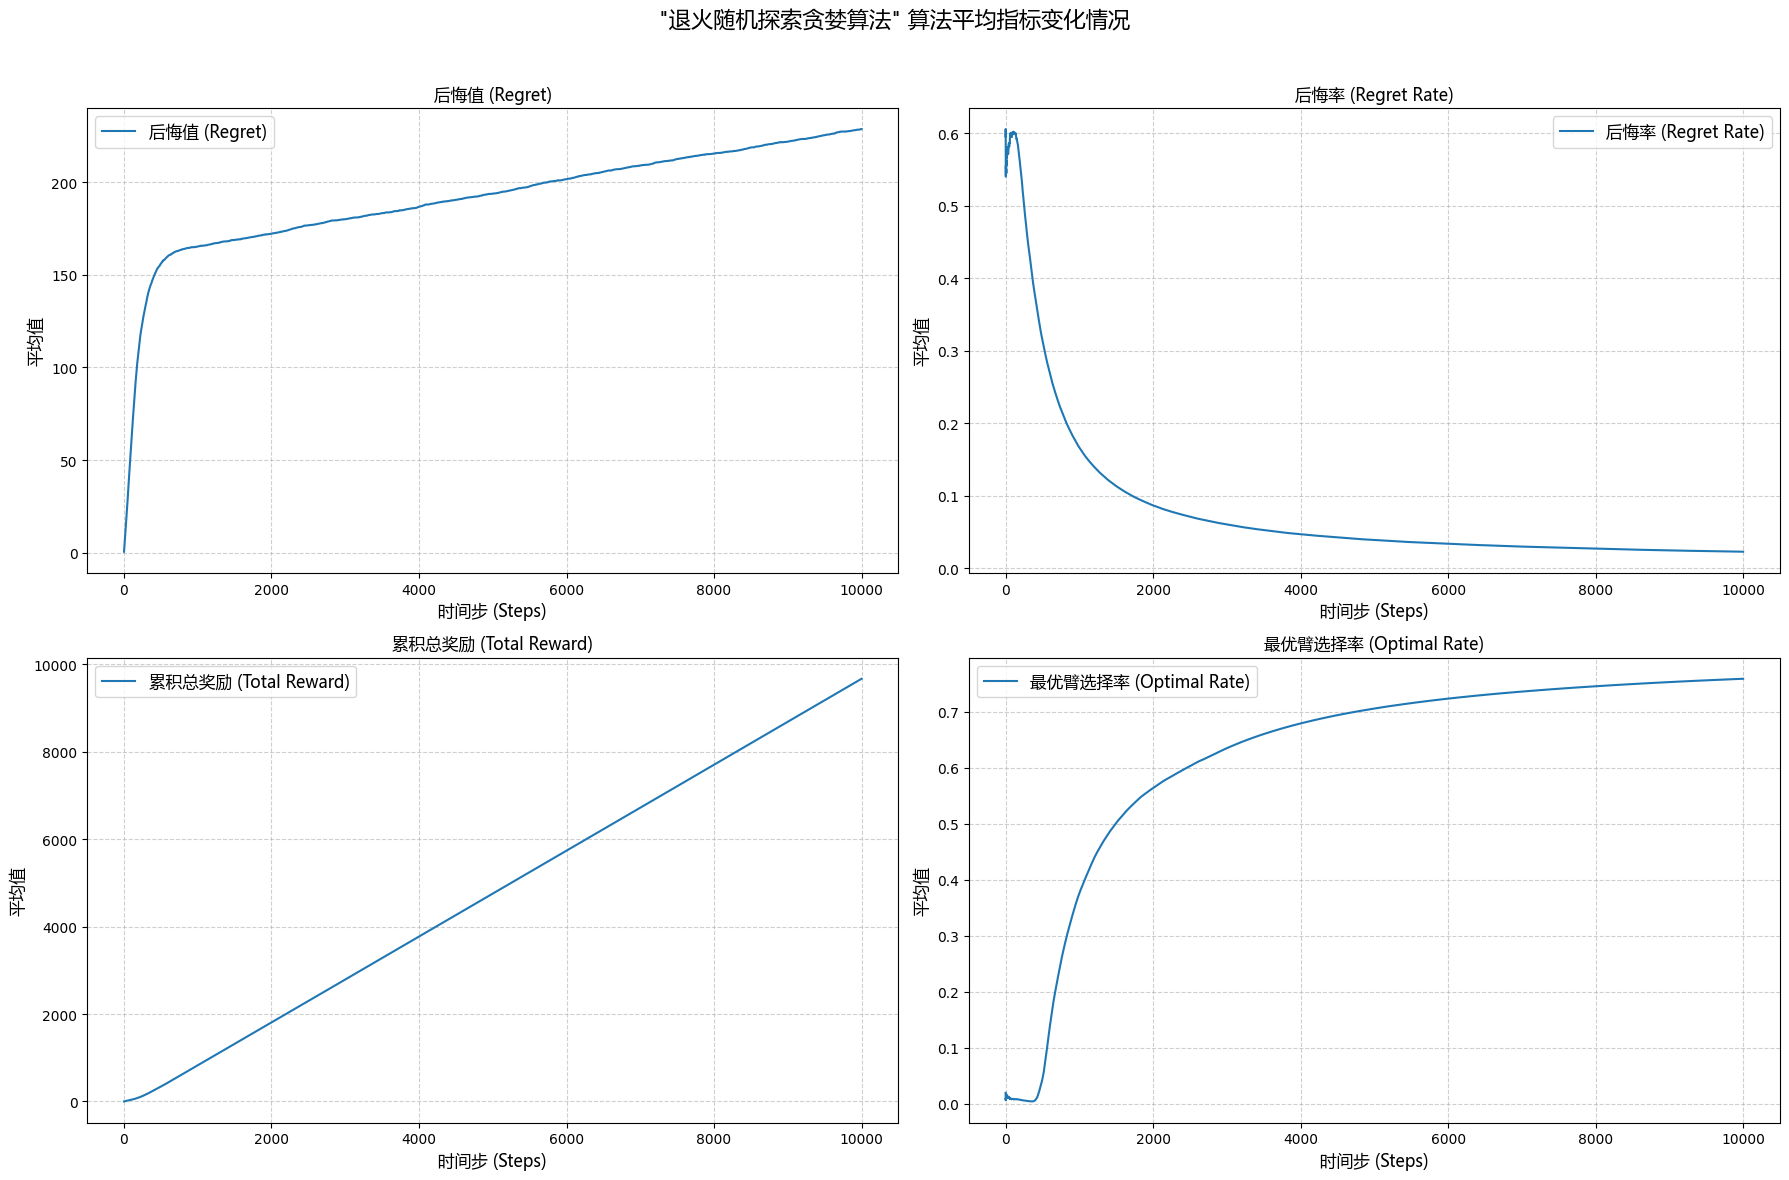

anget 名称: epsilon_decreasing_average
平均奖励：values=[0.02, 0.04, 0.06, 0.04, 0.08, 0.16, 0.12, 0.22, 0.24, 0.26, 0.36, 0.32, 0.42, 0.36, 0.48, 0.44, 0.58, 0.46, 0.5, 0.66, 0.7, 0.74, 0.78, 0.54, 0.76, 0.74, 0.74, 0.7, 0.8, 0.9, 0.92, 1.0, 1.34, 1.1, 1.06, 1.26, 1.2, 1.14, 1.28, 1.26, 1.18, 1.26, 1.26, 1.24, 1.36, 1.5, 1.36, 1.62, 1.44, 1.36, 1.72, 2.04, 1.78, 1.86, 2.04, 2.26, 2.04, 2.12, 2.2, 2.16, 2.4, 2.26, 2.78, 2.38, 2.72, 2.56, 2.42, 2.5, 3.48, 3.08, 3.72, 3.44, 3.62, 3.64, 3.42, 4.68, 4.78, 4.74, 5.5, 6.1, 5.88, 6.52, 6.84, 7.3, 8.0, 8.4, 8.28, 10.38, 8.6, 8.4, 9.16, 9.44, 12.44, 13.88, 17.18, 20.8, 36.52, 205.14, 1626.62, 7513.78] counts=[3.56, 4.08, 3.68, 3.52, 3.1, 3.4, 3.62, 3.42, 3.58, 3.14, 3.28, 3.48, 3.38, 3.9, 3.74, 3.58, 3.92, 3.24, 3.5, 3.24, 3.72, 3.56, 3.7, 2.98, 3.52, 3.56, 3.84, 3.48, 3.6, 3.54, 3.62, 3.58, 4.12, 4.06, 3.72, 3.98, 3.88, 3.9, 4.06, 3.86, 3.56, 3.64, 3.74, 3.6, 3.76, 3.92, 3.5, 4.0, 3.68, 3.34, 3.88, 4.42, 3.76, 3.96, 4.08, 4.46, 4.04, 4.04, 4.12, 4.04

In [6]:
agents, reward , metrics= batch_train(
    count=COUNT,
    greedy_algorithm=epsilon_decreasing_average,
    env=env, 
    epsilon_config=EpsilonDecreasingConfig(),
    steps=STEPS,
    optimistic_init=True,
    seed=SEED
)

plot_metrics_history(agents=agents, agent_name="退火随机探索贪婪算法")

print(
    f"anget 名称: {agents[0].name}"
    f"\n平均奖励：{reward}"
    f"\n指标：{metrics}"
)